# **Sentiment Analysis**

## **Import Libraries**

In [1]:
#general purpose libraries 
import re
import time
import pandas as pd
from pandas import pivot_table
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)

In [2]:
# NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
#Modelling 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

### **Import the raw data**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
## load the sample data 
product_review=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone Project/sample30.csv")

## **Data Cleaning**


In [69]:
def basic_details(data):
    table_detail=pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
    table_detail= table_detail.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'Null Values'}))
    table_detail= table_detail.append(round(pd.DataFrame(data.isnull().sum()/len(data)*100),2).T.rename(index={0:'Missing Values%'}))
    table_detail= table_detail.append(pd.DataFrame(data.nunique()).T.rename(index={0:'Unique Count'}))
    table_detail= table_detail.append(pd.DataFrame(data.loc[0,:]).T.rename(index={0:'Sample Record'}))
    display(table_detail.T)

In [70]:
basic_details(product_review)

,column type,Null Values,Missing Values%,Unique Count,Sample Record
id,object,0,0,271,AV13O1A8GV-KLJ3akUyj
brand,object,0,0,214,Universal Music
categories,object,0,0,270,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap"
manufacturer,object,141,0.47,227,Universal Music Group / Cash Money
name,object,0,0,271,Pink Friday: Roman Reloaded Re-Up (w/dvd)
reviews_date,object,46,0.15,6857,2012-11-30T06:21:45.000Z
reviews_didPurchase,object,14068,46.89,2,NaN
reviews_doRecommend,object,2570,8.57,2,NaN
reviews_rating,int64,0,0,5,5
reviews_text,object,0,0,27282,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.


In [71]:
LEN_DATASET=len(product_review)
product_review.dropna(thresh = LEN_DATASET*0.5, axis = 1, inplace = True) ## Removing the columns will more missing values

In [72]:
product_review.drop(columns=['reviews_doRecommend','reviews_didPurchase'],inplace=True)

In [73]:
product_review.reviews_title.fillna(' ', inplace = True)

In [74]:
product_review['reviews']=product_review['reviews_title']+'. '+product_review['reviews_text'] # combine 2 columns to arive a new column
product_review.drop(columns=['reviews_title','reviews_text'],inplace=True) # dropping the columns are we already have the column copy 

In [75]:
basic_details(product_review)

,column type,Null Values,Missing Values%,Unique Count,Sample Record
id,object,0,0,271,AV13O1A8GV-KLJ3akUyj
brand,object,0,0,214,Universal Music
categories,object,0,0,270,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap"
manufacturer,object,141,0.47,227,Universal Music Group / Cash Money
name,object,0,0,271,Pink Friday: Roman Reloaded Re-Up (w/dvd)
reviews_date,object,46,0.15,6857,2012-11-30T06:21:45.000Z
reviews_rating,int64,0,0,5,5
reviews_username,object,63,0.21,24914,joshua
user_sentiment,object,1,0,2,Positive
reviews,object,0,0,29016,Just Awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.


In [76]:
product_review.dropna(inplace=True)

In [77]:
basic_details(product_review)

,column type,Null Values,Missing Values%,Unique Count,Sample Record
id,object,0,0,268,AV13O1A8GV-KLJ3akUyj
brand,object,0,0,212,Universal Music
categories,object,0,0,267,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap"
manufacturer,object,0,0,225,Universal Music Group / Cash Money
name,object,0,0,268,Pink Friday: Roman Reloaded Re-Up (w/dvd)
reviews_date,object,0,0,6808,2012-11-30T06:21:45.000Z
reviews_rating,int64,0,0,5,5
reviews_username,object,0,0,24759,joshua
user_sentiment,object,0,0,2,Positive
reviews,object,0,0,28774,Just Awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.


In [78]:
len(product_review)/LEN_DATASET

0.9918333333333333

Text(0.5, 1.0, 'Users Rating distribution')

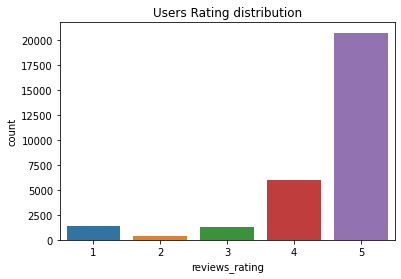

In [79]:
sns.countplot(product_review.reviews_rating)
plt.title("Users Rating distribution")

Text(0.5, 1.0, 'Sentiment distribution')

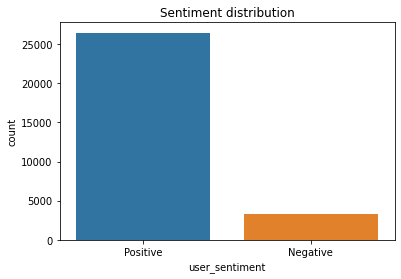

In [80]:
sns.countplot(product_review.user_sentiment)
plt.title("Sentiment distribution")

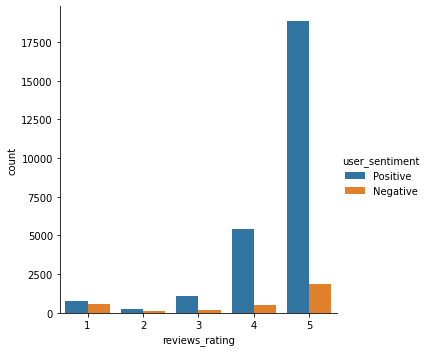

In [81]:
sns.catplot(data=product_review,kind='count',x='reviews_rating',hue='user_sentiment')

In [82]:
## As we have positve and negative categories with low and high rating hence to clean the data we are considering the data <3 as negative sentiment and remaining as postivie sentiment
product_review['user_sentiment']=product_review.reviews_rating.apply(lambda x: 0 if x<3 else 1)

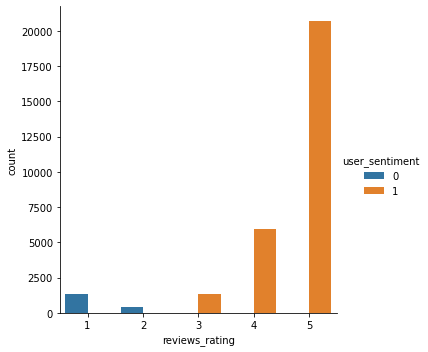

In [83]:
sns.catplot(data=product_review,kind='count',x='reviews_rating',hue='user_sentiment')

Text(0.5, 1.0, 'Sentiment distribution')

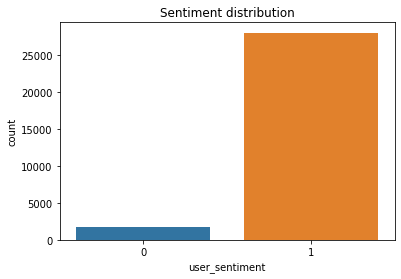

In [84]:
sns.countplot(product_review.user_sentiment)
plt.title("Sentiment distribution")

## **Text Pre-Processing**

In [85]:
product_review.reviews.head()

0                                                                                        Just Awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1                                                                                                                                                                                                                                           Good. Good flavor. This review was collected as part of a promotion.
2                                                                                                                                                                                                                                                                                             Good. Good flavor.
3    Disappointed. I read through the reviews on here before looking in to buying one

In [86]:
def scrub_words(text):
  text=text.lower()  
  text=re.sub(r"[^\w\s]","",text) # to remove punctuations  
  text=re.sub("(<.*?>)","",text) # remove html markup
  text=re.sub(r"[\d]","",text) # to remove numbers
  text=re.sub("  "," ",text)  # to remove extra spaces
  return text  

In [87]:
product_review['reviews']=product_review.reviews.apply(lambda x: scrub_words(x)) 

In [88]:
product_review.reviews.head()

0                                                                                                   just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it star rating all the way her metaphors are just crazy
1                                                                                                                                                                                                                                              good good flavor this review was collected as part of a promotion
2                                                                                                                                                                                                                                                                                               good good flavor
3    disappointed i read through the reviews on here before looking in to buying one 

In [89]:
# Remove Stopwords
stop = stopwords.words('english')
product_review['reviews'] = product_review.reviews.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [90]:
# Lemmatization
wordnet_lmtzer = WordNetLemmatizer()
def lemmatize_document(document):
    document = " ".join([wordnet_lmtzer.lemmatize(word) for word in word_tokenize(document)])
    return document

In [91]:
product_review['reviews'] = product_review['reviews'].apply(lambda x: lemmatize_document(x))

In [92]:
product_review.reviews.head()

0                                                                                                                                                                                            awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1                                                                                                                                                                                                                                                               good good flavor review collected part promotion
2                                                                                                                                                                                                                                                                                               good good flavor
3    disappointed read review looking buying one couple lubricant ultimately disappoi

In [93]:
df=product_review.copy()

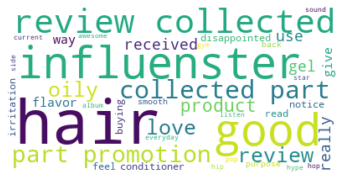

In [ ]:
wc = WordCloud(stopwords=stop,background_color="white",min_font_size=2,max_words=40).generate(str(product_review['reviews']))

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

## **Modeling**

### **Train Test Split**

In [ ]:
# Split the dataset into test and train
seed = 50 

X_train, X_test, y_train, y_test = train_test_split(product_review['reviews'], product_review['user_sentiment'], test_size=0.3, random_state=seed)

### **Text Vectorizer**

In [ ]:
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step. 
    analyzer='word',            # Whether the feature should be made of word or character n-grams.
    token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'
    ngram_range=(1, 3),         # The lower and upper boundary of the range of n-values for different n-grams to be extracted
    stop_words='english',
    sublinear_tf=True)

word_vectorizer.fit(X_train)    # Fiting it on Train
train_word_features = word_vectorizer.transform(X_train)  # Transform on Train

In [ ]:
## transforming the train and test datasets
X_train_transformed = word_vectorizer.transform(X_train.tolist())
X_test_transformed = word_vectorizer.transform(X_test.tolist())

# # Print the shape of each dataset.
print('X_train_transformed', X_train_transformed.shape)
print('y_train', y_train.shape)
print('X_test_transformed', X_test_transformed.shape)
print('y_test', y_test.shape)

X_train_transformed (20828, 398320)
y_train (20828,)
X_test_transformed (8927, 398320)
y_test (8927,)


### **LR**

In [ ]:
# Build the Logistic Regression model.
time1 = time.time()

LR = LogisticRegression()
LR.fit(X_train_transformed,y_train)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 5.17 seconds


In [ ]:
def classification_metrics(Y,Y_Pred,Model):
  cm = confusion_matrix(Y, Y_Pred, labels=Model.classes_)
  sns.heatmap(cm/np.sum(cm), annot=True , fmt = ' .2%')
  plt.show()
  print(classification_report(Y_Pred, Y))  
  TN = cm[0, 0] 
  FP = cm[0, 1]
  FN = cm[1, 0]
  TP = cm[1, 1]
  sensitivity = TP / float(FN + TP) 
  print("sensitivity: ",sensitivity)
  specificity = TN / float(TN + FP)
  print("specificity ",specificity)

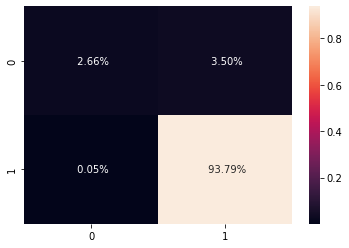

              precision    recall  f1-score   support

           0       0.43      0.98      0.60       565
           1       1.00      0.96      0.98     20263

    accuracy                           0.96     20828
   macro avg       0.72      0.97      0.79     20828
weighted avg       0.98      0.96      0.97     20828

sensitivity:  0.9994883340155546
specificity  0.4322429906542056


In [ ]:
# Prediction Train Data
y_pred_train= LR.predict(X_train_transformed)

classification_metrics(y_train, y_pred_train,LR)

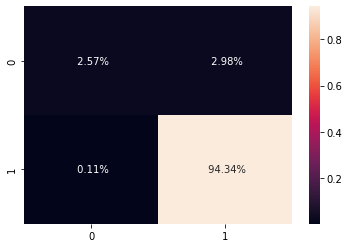

              precision    recall  f1-score   support

           0       0.46      0.96      0.62       239
           1       1.00      0.97      0.98      8688

    accuracy                           0.97      8927
   macro avg       0.73      0.96      0.80      8927
weighted avg       0.98      0.97      0.97      8927

sensitivity:  0.9988140417457305
specificity  0.4626262626262626


In [ ]:
# Prediction Test Data
y_pred_test= LR.predict(X_test_transformed)

classification_metrics(y_test, y_pred_test,LR)

Due to class imblance many Negative ratings are captured as Positive

In [ ]:
sm = SMOTE()

# transform the dataset
X_train_transformed_sm, y_train_sm = sm.fit_resample(X_train_transformed, y_train)


In [ ]:
# Building the Logistic Regression model
time1 = time.time()

LR = LogisticRegression()
LR.fit(X_train_transformed_sm,y_train_sm)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 9.52 seconds


In [ ]:
def ClassificationPredict(model):
  # Prediction Train Data
  print("Train Prediction")
  y_pred_train= model.predict(X_train_transformed_sm)
  classification_metrics(y_train_sm, y_pred_train,model)

  # Prediction Test Data
  print("Test Prediction") 
  y_pred_test= model.predict(X_test_transformed)
  classification_metrics(y_test, y_pred_test,model)

Train Prediction


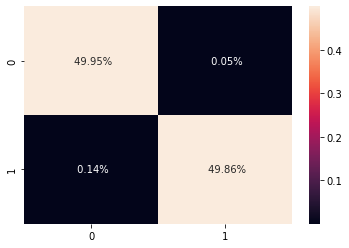

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19576
           1       1.00      1.00      1.00     19512

    accuracy                           1.00     39088
   macro avg       1.00      1.00      1.00     39088
weighted avg       1.00      1.00      1.00     39088

sensitivity:  0.9972881702824397
specificity  0.9989255014326648
Test Prediction


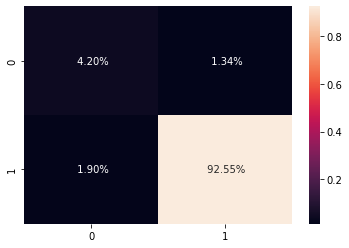

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       545
           1       0.98      0.99      0.98      8382

    accuracy                           0.97      8927
   macro avg       0.87      0.84      0.85      8927
weighted avg       0.97      0.97      0.97      8927

sensitivity:  0.9798387096774194
specificity  0.7575757575757576


In [ ]:
ClassificationPredict(LR)

## **NAIVE BASE**

In [ ]:
mnb = MultinomialNB()

time1 = time.time()

mnb = MultinomialNB()
mnb.fit(X_train_transformed_sm,y_train_sm)


time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 0.06 seconds


Train Prediction


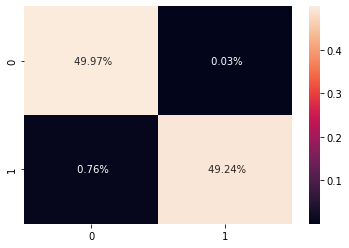

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19830
           1       0.98      1.00      0.99     19258

    accuracy                           0.99     39088
   macro avg       0.99      0.99      0.99     39088
weighted avg       0.99      0.99      0.99     39088

sensitivity:  0.9848035202619729
specificity  0.9994371674171101
Test Prediction


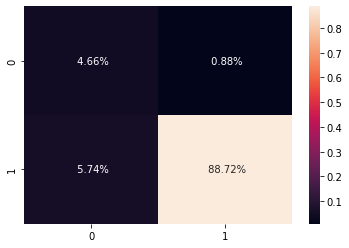

              precision    recall  f1-score   support

           0       0.84      0.45      0.58       928
           1       0.94      0.99      0.96      7999

    accuracy                           0.93      8927
   macro avg       0.89      0.72      0.77      8927
weighted avg       0.93      0.93      0.92      8927

sensitivity:  0.9392789373814042
specificity  0.8404040404040404


In [ ]:
ClassificationPredict(mnb)

## **Random Forest**

In [ ]:
time1 = time.time()

RF = RandomForestClassifier(n_estimators=25, random_state=seed, n_jobs=-1)
RF.fit(X_train_transformed_sm,y_train_sm)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 22.84 seconds


Train Prediction


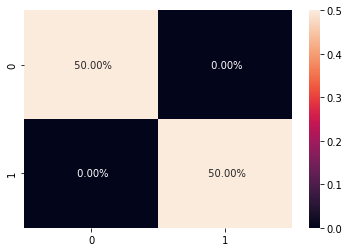

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19543
           1       1.00      1.00      1.00     19545

    accuracy                           1.00     39088
   macro avg       1.00      1.00      1.00     39088
weighted avg       1.00      1.00      1.00     39088

sensitivity:  1.0
specificity  0.9999488334015555
Test Prediction


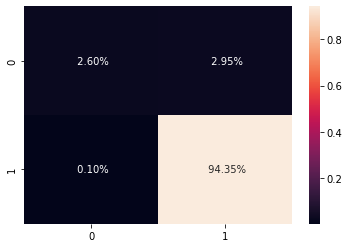

              precision    recall  f1-score   support

           0       0.47      0.96      0.63       241
           1       1.00      0.97      0.98      8686

    accuracy                           0.97      8927
   macro avg       0.73      0.97      0.81      8927
weighted avg       0.98      0.97      0.97      8927

sensitivity:  0.9989326375711575
specificity  0.4686868686868687


In [ ]:
ClassificationPredict(RF)

### **Hyperparameter Tuning**

In [ ]:
# Create first pipeline for base without reducing features.
time1 = time.time()
pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [RandomForestClassifier()],
     'classifier__n_estimators' : [10,20,30] ,
    'classifier__max_features' : ['auto', 'sqrt'],
    'classifier__max_depth' : [4,5,6]  ,
    'classifier__min_samples_split' : [2, 5, 10],
    'classifier__min_samples_leaf' : [1, 2, 4]}     
]

# Create grid search object
RF_HP = RandomizedSearchCV(pipe, param_distributions = param_grid, cv = 3, verbose=True, n_jobs=-1,n_iter=5, random_state=42)


RF_HP.fit(X_train_transformed_sm,y_train_sm)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Time Taken: 17.02 seconds


Train Prediction


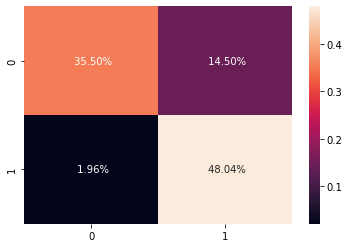

              precision    recall  f1-score   support

           0       0.71      0.95      0.81     14641
           1       0.96      0.77      0.85     24447

    accuracy                           0.84     39088
   macro avg       0.84      0.86      0.83     39088
weighted avg       0.87      0.84      0.84     39088

sensitivity:  0.9608575521899304
specificity  0.7099877200163733
Test Prediction


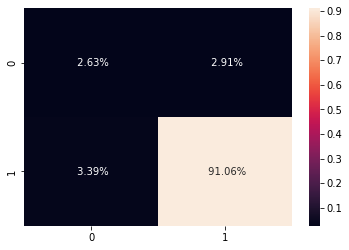

              precision    recall  f1-score   support

           0       0.47      0.44      0.45       538
           1       0.96      0.97      0.97      8389

    accuracy                           0.94      8927
   macro avg       0.72      0.70      0.71      8927
weighted avg       0.93      0.94      0.94      8927

sensitivity:  0.9640654648956357
specificity  0.47474747474747475


In [ ]:
ClassificationPredict(RF_HP.best_estimator_)

In [ ]:
RF_HP.best_estimator_

Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        min_samples_leaf=4, min_samples_split=5,
                                        n_estimators=30))])

In [ ]:
# Create first pipeline for base without reducing features.
time1 = time.time()
pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [RandomForestClassifier()],
     'classifier__n_estimators' : [25,27,29,30,33,35] ,
    'classifier__max_features' : ['auto', 'sqrt'],
    'classifier__max_depth' : [1,2,3,4,5]  ,
    'classifier__min_samples_split' : [2,3,4,5,6,8,9,10],
    'classifier__min_samples_leaf' : [2,3,4,5,6,8,9,10]}     
]

# Create grid search object
RF_HP_1 = RandomizedSearchCV(pipe, param_distributions = param_grid, cv = 5, verbose=True, n_jobs=-1,n_iter=5, random_state=42)


RF_HP_1.fit(X_train_transformed_sm,y_train_sm)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Time Taken: 23.95 seconds


Train Prediction


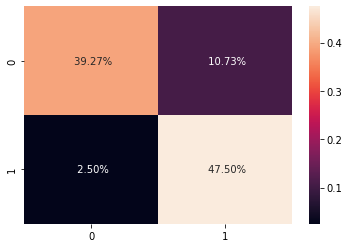

              precision    recall  f1-score   support

           0       0.79      0.94      0.86     16327
           1       0.95      0.82      0.88     22761

    accuracy                           0.87     39088
   macro avg       0.87      0.88      0.87     39088
weighted avg       0.88      0.87      0.87     39088

sensitivity:  0.9500613999181334
specificity  0.785458452722063
Test Prediction


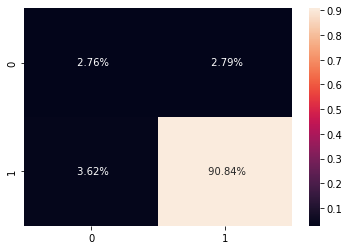

              precision    recall  f1-score   support

           0       0.50      0.43      0.46       569
           1       0.96      0.97      0.97      8358

    accuracy                           0.94      8927
   macro avg       0.73      0.70      0.71      8927
weighted avg       0.93      0.94      0.93      8927

sensitivity:  0.9616935483870968
specificity  0.49696969696969695


In [ ]:
ClassificationPredict(RF_HP1.best_estimator_)

In [ ]:
RF_HP1.best_estimator_

Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=6, min_samples_split=10,
                                        n_estimators=30))])

## **XGBoost Classifier**

In [ ]:
time1 = time.time()

XGB = XGBClassifier(n_estimators=25  , random_state=seed, n_jobs=-1)
XGB.fit(X_train_transformed_sm,y_train_sm)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 19.61 seconds


Train Prediction


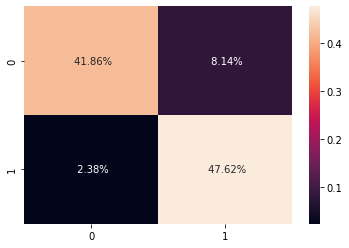

              precision    recall  f1-score   support

           0       0.84      0.95      0.89     17293
           1       0.95      0.85      0.90     21795

    accuracy                           0.89     39088
   macro avg       0.89      0.90      0.89     39088
weighted avg       0.90      0.89      0.90     39088

sensitivity:  0.9524150634465821
specificity  0.8372390503479329
Test Prediction


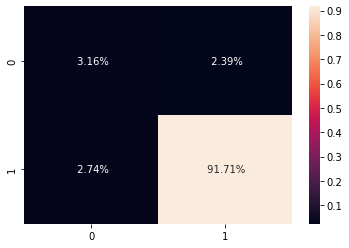

              precision    recall  f1-score   support

           0       0.57      0.54      0.55       527
           1       0.97      0.97      0.97      8400

    accuracy                           0.95      8927
   macro avg       0.77      0.75      0.76      8927
weighted avg       0.95      0.95      0.95      8927

sensitivity:  0.9709440227703985
specificity  0.5696969696969697


In [ ]:
ClassificationPredict(XGB)

In [ ]:
# Create first pipeline for base without reducing features.
time1 = time.time()
pipe = Pipeline([('classifier' , XGBClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [XGBClassifier()],
     'classifier__n_estimators' : [25,27,29,30,33,35] ,
    'classifier__max_features' : ['auto', 'sqrt'],
    'classifier__max_depth' : [1,2,3,4,5]  ,
    'classifier__min_samples_split' : [2,3,4,5,6,8,9,10],
    'classifier__min_samples_leaf' : [2,3,4,5,6,8,9,10]}     
]

# Create grid search object
XG_HP = RandomizedSearchCV(pipe, param_distributions = param_grid, cv = 5, verbose=True, n_jobs=-1,n_iter=5, random_state=42)


XG_HP.fit(X_train_transformed_sm,y_train_sm)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Time Taken: 571.77 seconds


Train Prediction


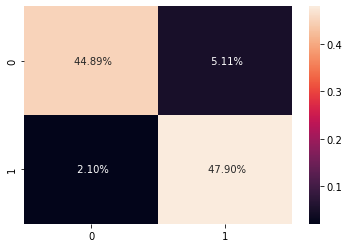

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     18369
           1       0.96      0.90      0.93     20719

    accuracy                           0.93     39088
   macro avg       0.93      0.93      0.93     39088
weighted avg       0.93      0.93      0.93     39088

sensitivity:  0.9579922226770364
specificity  0.8978714695047073
Test Prediction


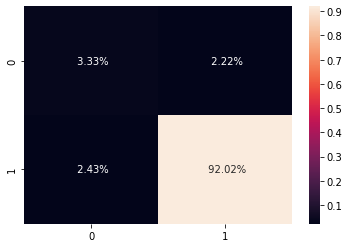

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       514
           1       0.97      0.98      0.98      8413

    accuracy                           0.95      8927
   macro avg       0.79      0.78      0.78      8927
weighted avg       0.95      0.95      0.95      8927

sensitivity:  0.9742647058823529
specificity  0.6


In [ ]:
ClassificationPredict(XG_HP)

In [ ]:
XG_HP.best_estimator_

Pipeline(steps=[('classifier',
                 XGBClassifier(max_depth=5, max_features='sqrt',
                               min_samples_leaf=3, min_samples_split=2,
                               n_estimators=30))])

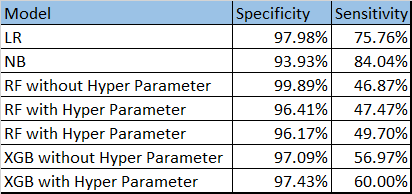

In [ ]:
pickle.dump(mnb, open('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Model/NB.pkl','wb'))

In [6]:
FINAL_MODEL=pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Model/NB.pkl','rb'))

In [ ]:
pickle.dump(word_vectorizer, open('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Model/WordVecpkl.pkl','wb'))

In [7]:
FINAL_WordVec=pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Model/WordVecpkl.pkl','rb'))

# **Recommendation System**

Steps to be performed are as follows
1.   Prepare the Train Test Split
2.   Train Pivot and Train Dummy Pivot
3.   Adjusted Correlation
4.   Item Correlation
5.   Predict Final Rating
6.   Common Item and Common Pivot and Common Dummy
7.   Item Correlation matching to test data
8.   Common Predicted rating and RMSE


In [8]:
## load the sample data 
product_review=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone Project/sample30.csv")

In [9]:
## cleaning the target variable based on the ratings provided
product_review['positive']=product_review.reviews_rating.apply(lambda X: 1 if X>2.5 else 0)

In [10]:
product_review.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,positive
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive,1
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive,1
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive,1
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,NaN,NaN,rebecca,Negative,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative,0


### **Test Train Split**

In [11]:
seed = 50 

train, test= train_test_split(product_review, test_size=0.3, random_state=seed)

## **User User Recomendation**

### **User Pivot Table and Dummy Pivot**

In [12]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
user_pivot = pivot_table(train,index='reviews_username',columns='name',values='reviews_rating')
user_pivot.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Every Man Jack Pomade Signature Mint Scent,Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange

In [13]:
dummy_train= train.copy()
dummy_train['reviews_rating']=dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)
train_dummy_pivot = pivot_table(train,index='reviews_username',columns='name',values='reviews_rating').fillna(1)
train_dummy_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Every Man Jack Pomade Signature Mint Scent,Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange

### **Adjusted Correlation**

In [14]:
#Normalising the rating of the products for each user around 0 mean
mean=np.nanmean(user_pivot, axis=1)

In [15]:
user_pivot_std= (user_pivot.T-mean).T

In [16]:
user_pivot_std.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Every Man Jack Pomade Signature Mint Scent,Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange

### **User Corelation**

In [17]:
user_correlation=1-pairwise_distances(user_pivot_std.fillna(0), metric='cosine')

In [18]:
user_correlation[np.isnan(user_correlation)] = 0
user_correlation[user_correlation<0]=0

In [19]:
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
np.shape(user_correlation)

(18283, 18283)

### **Predit Product Rating**


We are predicting rating of Product by the user is the correlation with the movie rating. 

In [21]:
user_predict_rating=np.dot(user_correlation,user_pivot.fillna(0))

We are only predicting the rating for the products not rated by the users we multiply with the dummy train created

In [22]:
user_final_predict_rating=np.multiply(user_predict_rating,train_dummy_pivot)

In [23]:
user_id= input("Enter the userid")
print(user_id)

Enter the useriddave
dave


In [24]:
d=user_final_predict_rating.loc[user_id].sort_values(ascending=False)[:5]
d

name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                    263.806186
Mike Dave Need Wedding Dates (dvd + Digital)                                       184.193121
Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter     85.380459
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                 27.796500
Nexxus Exxtra Gel Style Creation Sculptor                                           26.203878
Name: dave, dtype: float64

In [25]:
print(test.shape)
common = test[test.reviews_username.isin(train.reviews_username)]
print(common.shape)

(9000, 16)
(2075, 16)


## **Item Item Recomendation**

### **Product Pivot Table and Dummy Pivot**

In [26]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
product_pivot = pivot_table(train, values='reviews_rating',columns='reviews_username',index='name')
product_pivot.head(3)

reviews_username,00dog3,00sab00,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,12cass12,13dani,13ld,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,170361eggs,1753,17roses,18612,1863philly,1943,1950rmm,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,1awesome1,1boomer,1buzymom,1cadet,1chynna,1cleaner,1cocoafan,1derpet1,1friendlycat,1gamer,1gra,1healthytot,1hotmama,1izzy1,1jodie,1kindword,1movielover2,1officegal,1pleasedclient,1scooby1,1shop,1sonny,1stcavdivision,1stgrade,1stlady,1sungirl,1texasmom,1wildbill2l,1witch,2011mom2b,2016,2016home,2062351337,20crafter16,210tundra,2175046722,232323,23jen,2455,24hrstoneroses,2532674594,262jennifer,295259,2athome,2bgreen,2big,2busy4u,2clean4me,2cutekids,2dobies,2ds4es14,2forhokies,2go4savings,2hearts1love,...,yoyo1245,yozer29,ypryor,yram,yrina03,yshan,yttric,yucky111,yulkakapulka,yummy,yunji,yvonne,yyz2112123,yzkgsx,z12345,z33pisces,z992,zabdelra,zach,zacharymcneill,zacharysaunt,zachizz,zachsmom,zacroxs,zaibo,zak,zak08,zakkwylde29,zamanda,zanarkandruinsx2,zapaduh,zapman,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zebrastrong,zeek,zeek09,zeeleader,zegan,zenanuts,zenmon,zeramm,zero,zeroonec,zfem2,zhio,zhjwpp,zhynellebb,zibber23,zibby4,ziggy,zillafan,zillanator,zina911,zink,zinnian,zipper,zipperdoo,zippity,zippy,zitro,zittles,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zoe1988,zoey,zoeyny,zombie,zombiedad80,zombiegirl22,zombiekiller,zombiekiller14,zoney86,zooey_57,zoso60,zotox,zout22389,zowie,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzz1127
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [27]:
train_dummy_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Every Man Jack Pomade Signature Mint Scent,Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange

### **Adjusted Similarity**

In [28]:
mean = np.nanmean(product_pivot, axis=1)
product_pivot_std = (product_pivot.T-mean).T

In [29]:
product_pivot_std.head()

reviews_username,00dog3,00sab00,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,12cass12,13dani,13ld,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,170361eggs,1753,17roses,18612,1863philly,1943,1950rmm,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,1awesome1,1boomer,1buzymom,1cadet,1chynna,1cleaner,1cocoafan,1derpet1,1friendlycat,1gamer,1gra,1healthytot,1hotmama,1izzy1,1jodie,1kindword,1movielover2,1officegal,1pleasedclient,1scooby1,1shop,1sonny,1stcavdivision,1stgrade,1stlady,1sungirl,1texasmom,1wildbill2l,1witch,2011mom2b,2016,2016home,2062351337,20crafter16,210tundra,2175046722,232323,23jen,2455,24hrstoneroses,2532674594,262jennifer,295259,2athome,2bgreen,2big,2busy4u,2clean4me,2cutekids,2dobies,2ds4es14,2forhokies,2go4savings,2hearts1love,...,yoyo1245,yozer29,ypryor,yram,yrina03,yshan,yttric,yucky111,yulkakapulka,yummy,yunji,yvonne,yyz2112123,yzkgsx,z12345,z33pisces,z992,zabdelra,zach,zacharymcneill,zacharysaunt,zachizz,zachsmom,zacroxs,zaibo,zak,zak08,zakkwylde29,zamanda,zanarkandruinsx2,zapaduh,zapman,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zebrastrong,zeek,zeek09,zeeleader,zegan,zenanuts,zenmon,zeramm,zero,zeroonec,zfem2,zhio,zhjwpp,zhynellebb,zibber23,zibby4,ziggy,zillafan,zillanator,zina911,zink,zinnian,zipper,zipperdoo,zippity,zippy,zitro,zittles,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zoe1988,zoey,zoeyny,zombie,zombiedad80,zombiegirl22,zombiekiller,zombiekiller14,zoney86,zooey_57,zoso60,zotox,zout22389,zowie,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzz1127
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,0.28125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

### **Product Correlation**

In [30]:
product_correlation = 1 - pairwise_distances(product_pivot_std.fillna(0), metric='cosine')
product_correlation[np.isnan(product_correlation)] = 0
product_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [31]:
np.shape(product_correlation)

(252, 252)

### **Predict Product rating**

In [32]:
product_predict_rating=np.dot(product_correlation,product_pivot.fillna(0))

In [33]:
product_final_predict_rating=np.multiply(product_predict_rating,train_dummy_pivot.T)

In [34]:
user_id= input("Enter the userid")
print(user_id)

Enter the useriddave
dave


In [35]:
d=product_final_predict_rating.T.loc[user_id].sort_values(ascending=False)[:5]
d

name
Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter    25.043791
Mike Dave Need Wedding Dates (dvd + Digital)                                       24.934230
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                    20.162962
Nexxus Exxtra Gel Style Creation Sculptor                                           0.977124
Chester's Cheese Flavored Puffcorn Snacks                                           0.194889
Name: dave, dtype: float64

## **Evaluation**

### **Common Item and Common Pivot and Common Dummy**

In [36]:
common= test[test.reviews_username.isin(train.reviews_username)]

In [37]:
common.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,positive
5489,AVpf0thK1cnluZ0-r8vR,Warner Bros.,"Movies, Music & Books,Movies,New Movie Releases,Ways To Shop Entertainment,Tv Box Sets,Movies & TV,Blu-ray,Television,Box Sets,Movies & Music,Movies & TV Shows,Movies New Releases,Movies & Tv On Blu-ray,Movies & Tv On Blu-ray New Releases,Tv Shows,Tv Show New Releases,Action & Adventure,Drama,St...",Warner Home Video,100:Complete First Season (blu-Ray),2015-06-14T00:00:00.000Z,NaN,True,5,"The 100 is well worth any sci-fi fan?? time, going all-in on its big concept and the many crisis that face its characters, both above and on the ground.",The 100,NaN,NaN,gamerguy,Positive,1
29047,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,2017-01-21T01:09:05.000Z,NaN,NaN,3,I received this conditioner for free in exchange for my honest review. I think that this conditioner works fine. It is not anything special and does what it is supposed to do. However I would not say that it keeps my hair feeling soft for 48 hours. This review was collected as part of a promotion.,Conditioner,NaN,NaN,emily1108,Positive,1
16108,AVpf63aJLJeJML43F__Q,Burt's Bees,"Personal Care,Makeup,Lipstick, Lip Gloss, & Lip Balm,Lip Gloss,Beauty,Lips,Beauty & Personal Care,Skin Care,Lip Care,Lip Balms & Treatments",Burt's Bees,"Burt's Bees Lip Shimmer, Raisin",2013-01-07T00:00:00.000Z,False,True,5,"I love my Burt's Lip Shimmer in Cocoa and am almost out! I stock up when I find a lip color I love, please, please, please bring back, was the best ever!!!",Love this in Cocoa!!!,NaN,NaN,genk,Positive,1
26500,AVpfPPkEilAPnD_xX3cP,Aveeno,"Personal Care,Sun Care,Featured Brands,Health & Beauty,Johnson & Johnson Beauty,Johnson & Johnson,Beauty,Skin Care,Sun & Tanning,Health,Beauty & Personal Care,Sunscreens & Tanning Products,Sunscreens,Facial Sunscreens,Sun Protection & Tanning,Sunscreen,Body Sunscreens,Health & Wellness,Sun Prote...",Aveeno Baby,"Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",2017-02-03T00:00:00.000Z,NaN,NaN,1,baby is allergic.,be careful,NaN,NaN,byamazon customer,Negative,0
27162,AVpfRoqcLJeJML436FqG,Vicks,"Personal Care,Medicine Cabinet,Cough/Cold,Health,Cough, Cold & Flu,Health & Beauty,Health Care,Over-the-Counter Medicine,Health & Household,Medications & Treatments,Cough & Cold,Chest Rubs,Health & Wellness,Allergy & Sinus",P&G,"Vicks Vaporub, Regular, 3.53oz",2017-01-20T00:00:00.000Z,True,True,5,Been using this for years,Vicks VapoRub,NaN,NaN,larry,Negative,1


In [38]:
common_pivot=pivot_table(common,index='reviews_username',columns='name',values='reviews_rating')

In [39]:
common_pivot.head()

name,100:Complete First Season (blu-Ray),Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Beanitos Bean Chips, Simply Pinto Bean",Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne","Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Gain Original Scent Liquid Fabric Softener 129 Oz,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Home Health Hairever Shampoo,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",Jason Aldean - They Don't Know,"Jergens Extra Moisturizing Liquid Hand Wash, 7.5oz","Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",K-Y Love Sensuality Pleasure Gel,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,L'oreal Paris Advanced Hairstyle Boost It High Lift Creation Spray,L'oreal Paris Advanced Hairstyle TXT IT Hyper-Fix Putty,Lundberg Organic Cinnamon Toast Rice Cakes,"Lundberg Wehani Rice, 25lb","Lysol Concentrate Deodorizing Cleaner, Original Scent",Meguiar's Ultimate Quik Detailer 22-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Mill Creek Aloe Vera & Paba Lotion,Moom Express Pre Waxed Strips For Face & Bikini,Mrs. Meyer's Lemon Verbena Surface Scrub,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,"Musselman Apple Sauce, Cinnamon, 48oz",My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nature's Path Chunky Chocolate Peanut Chewy Granola Bars,Naturtint Nutrideep Multiplier Protective Cream,Nearly Natural 5.5' Bamboo W/decorative Planter,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz","Newman's Own Balsamic Vinaigrette, 16.0oz",Nexxus Exxtra Gel Style Creation Sculptor,Ogx Anti-breakage Keratin Oil 3 Minute Miraculous Recovery,"Ogx Conditioner, Hydrating Teatree Mint",

In [40]:
test_dummy=common.copy()
test_dummy['reviews_rating']=test_dummy['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
test_dummy_pivot=pivot_table(test_dummy,index='reviews_username',columns='name',values='reviews_rating').fillna(0)
test_dummy_pivot.head()

name,100:Complete First Season (blu-Ray),Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Beanitos Bean Chips, Simply Pinto Bean",Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne","Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Gain Original Scent Liquid Fabric Softener 129 Oz,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Home Health Hairever Shampoo,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",Jason Aldean - They Don't Know,"Jergens Extra Moisturizing Liquid Hand Wash, 7.5oz","Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",K-Y Love Sensuality Pleasure Gel,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,L'oreal Paris Advanced Hairstyle Boost It High Lift Creation Spray,L'oreal Paris Advanced Hairstyle TXT IT Hyper-Fix Putty,Lundberg Organic Cinnamon Toast Rice Cakes,"Lundberg Wehani Rice, 25lb","Lysol Concentrate Deodorizing Cleaner, Original Scent",Meguiar's Ultimate Quik Detailer 22-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Mill Creek Aloe Vera & Paba Lotion,Moom Express Pre Waxed Strips For Face & Bikini,Mrs. Meyer's Lemon Verbena Surface Scrub,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,"Musselman Apple Sauce, Cinnamon, 48oz",My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nature's Path Chunky Chocolate Peanut Chewy Granola Bars,Naturtint Nutrideep Multiplier Protective Cream,Nearly Natural 5.5' Bamboo W/decorative Planter,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz","Newman's Own Balsamic Vinaigrette, 16.0oz",Nexxus Exxtra Gel Style Creation Sculptor,Ogx Anti-breakage Keratin Oil 3 Minute Miraculous Recovery,"Ogx Conditioner, Hydrating Teatree Mint",

## **User User Evaluation**

In [41]:
user_correlation_df=pd.DataFrame(user_correlation)

In [42]:
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,18183,18184,18185,18186,18187,18188,18189,18190,18191,18192,18193,18194,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211,18212,18213,18214,18215,18216,18217,18218,18219,18220,18221,18222,18223,18224,18225,18226,18227,18228,18229,18230,18231,18232,18233,18234,18235,18236,18237,18238,18239,18240,18241,18242,18243,18244,18245,18246,18247,18248,18249,18250,18251,18252,18253,18254,18255,18256,18257,18258,18259,18260,18261,18262,18263,18264,18265,18266,18267,18268,18269,18270,18271,18272,18273,18274,18275,18276,18277,18278,18279,18280,18281,18282
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [43]:
user_correlation_df.index=user_pivot_std.index
user_correlation_df.columns=user_pivot_std.index
user_correlation_df.head()

reviews_username,00dog3,00sab00,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,12cass12,13dani,13ld,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,170361eggs,1753,17roses,18612,1863philly,1943,1950rmm,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,1awesome1,1boomer,1buzymom,1cadet,1chynna,1cleaner,1cocoafan,1derpet1,1friendlycat,1gamer,1gra,1healthytot,1hotmama,1izzy1,1jodie,1kindword,1movielover2,1officegal,1pleasedclient,1scooby1,1shop,1sonny,1stcavdivision,1stgrade,1stlady,1sungirl,1texasmom,1wildbill2l,1witch,2011mom2b,2016,2016home,2062351337,20crafter16,210tundra,2175046722,232323,23jen,2455,24hrstoneroses,2532674594,262jennifer,295259,2athome,2bgreen,2big,2busy4u,2clean4me,2cutekids,2dobies,2ds4es14,2forhokies,2go4savings,2hearts1love,...,yoyo1245,yozer29,ypryor,yram,yrina03,yshan,yttric,yucky111,yulkakapulka,yummy,yunji,yvonne,yyz2112123,yzkgsx,z12345,z33pisces,z992,zabdelra,zach,zacharymcneill,zacharysaunt,zachizz,zachsmom,zacroxs,zaibo,zak,zak08,zakkwylde29,zamanda,zanarkandruinsx2,zapaduh,zapman,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zebrastrong,zeek,zeek09,zeeleader,zegan,zenanuts,zenmon,zeramm,zero,zeroonec,zfem2,zhio,zhjwpp,zhynellebb,zibber23,zibby4,ziggy,zillafan,zillanator,zina911,zink,zinnian,zipper,zipperdoo,zippity,zippy,zitro,zittles,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zoe1988,zoey,zoeyny,zombie,zombiedad80,zombiegirl22,zombiekiller,zombiekiller14,zoney86,zooey_57,zoso60,zotox,zout22389,zowie,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzz1127
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0

In [44]:
user_list_uc= common.reviews_username.tolist()

In [45]:
user_correlation_df=user_correlation_df[user_correlation_df.index.isin(user_list_uc)]
user_correlation_df=user_correlation_df.T[user_correlation_df.T.index.isin(user_list_uc)]
user_correlation_df=user_correlation_df.T
user_correlation_df.shape

(1746, 1746)

In [46]:
common_user_predicted_ratings = np.dot(user_correlation_df, common_pivot.fillna(0))
common_user_predicted_ratings

array([[0.       , 0.       , 0.3721042, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [47]:
common_user_finalpredict=np.multiply(test_dummy_pivot,common_user_predicted_ratings)

In [48]:
X= common_user_finalpredict.copy()
X=X[X>0]

scalar=MinMaxScaler(feature_range=(1, 5))
scalar.fit(X)
y=scalar.transform(X)

In [49]:
total_non_nan = np.count_nonzero(~np.isnan(y))

In [50]:
rmse = (sum(((common_pivot - y )**2).sum())/total_non_nan)**0.5
print(rmse)

2.5090306436033725


In [51]:
total_non_nan

312

## **Item Item Evaluation**

In [52]:
product_correlation_df=pd.DataFrame(product_correlation)

In [53]:
product_correlation_df.index=product_pivot_std.index
product_correlation_df.columns=product_pivot_std.index
product_correlation_df.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Every Man Jack Pomade Signature Mint Scent,Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange

In [54]:
product_list_pc= common.name.tolist()

In [55]:
product_correlation_df=product_correlation_df[product_correlation_df.index.isin(product_list_pc)]
product_correlation_df=product_correlation_df.T[product_correlation_df.T.index.isin(product_list_pc)]
product_correlation_df=product_correlation_df.T
product_correlation_df.shape

(131, 131)

In [56]:
product_correlation_df[product_correlation_df<0]=0

In [57]:
common_item_predicted_ratings = np.dot(product_correlation_df, common_pivot.fillna(0).T)

In [58]:
common_item_finalpredict=np.multiply(test_dummy_pivot.T,common_item_predicted_ratings)

In [59]:
X= common_item_finalpredict.copy()
X=X[X>0]

scalar=MinMaxScaler(feature_range=(1, 5))
scalar.fit(X)
y=scalar.transform(X)

In [60]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [61]:
rmse = (sum(((common_pivot.T - y )**2).sum())/total_non_nan)**0.5
print(rmse)

3.2882448197676855


In [62]:
pickle.dump(user_final_predict_rating, open('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Model/UserRating.pkl','wb'))

In [63]:
FINAL_RATING=pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Model/UserRating.pkl','rb'))

## **Recommendation**

In [64]:
# Using User based similarity system as its RMSE value is less than item based similarity system.
user_input = input("Enter your user name")
print(user_input)

Enter your user namedave
dave


In [65]:
d=FINAL_RATING.loc[user_input].sort_values(ascending=False)[:20]
d

name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                    263.806186
Mike Dave Need Wedding Dates (dvd + Digital)                                       184.193121
Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter     85.380459
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                 27.796500
Nexxus Exxtra Gel Style Creation Sculptor                                           26.203878
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                                23.135927
Red (special Edition) (dvdvideo)                                                    14.170792
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                           14.092694
The Resident Evil Collection 5 Discs (blu-Ray)                                      12.247874
Jason Aldean - They Don't Know                                                       7.464137
Clorox Disinfecting Bathroom Cleaner                   

In [66]:
# Define a function to recommend top 5 filtered products to the user.
def recommend(user_input):
    d = FINAL_RATING.loc[user_input].sort_values(ascending=False)[0:20]

    # Based on positive sentiment percentage.
    i= 0
    a = {}
    for prod_name in d.index.tolist():
      product_name = prod_name
      product_name_review_list =df[df['name']== product_name]['reviews'].tolist()
      features= FINAL_WordVec.transform(product_name_review_list)
      FINAL_MODEL.predict(features)
      a[product_name] = FINAL_MODEL.predict(features).mean()*100
    b= pd.Series(a).sort_values(ascending = False).head(5).index.tolist()
    print(b)

In [96]:
recommend(user_input)

['Batherapy Natural Mineral Bath Sport Liquid, 16 oz', 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total', 'Red (special Edition) (dvdvideo)', 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)', '100:Complete First Season (blu-Ray)']
